# 1 模块导入

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

C:\Users\LERRY\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [110]:
from sklearn.preprocessing import MinMaxScaler

In [1]:
#不用print即可输出多个变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
#plot中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 2 数据集合并与保存

### 2.1 数据导入

In [3]:
#定义加载数据集的方法
def load_dataset(path,inputfile):
    return pd.read_csv(path+inputfile)

In [4]:
#数据所在路径
path='data/enterprise_profit_forecast/'
#导入所有数据集
base_train=load_dataset(path,'base-train.csv')
base_test=load_dataset(path,'base-test.csv')
know_train=load_dataset(path,'knowledge-train.csv')
know_test=load_dataset(path,'knowledge-test.csv')
money_train=load_dataset(path,'money-train.csv')
money_test=load_dataset(path,'money-test.csv')
year_train=load_dataset(path,'year-train.csv')
year_test=load_dataset(path,'year-test.csv')

In [5]:
#数据集维度
print('base_train:',base_train.shape)
print('know_train:',know_train.shape)
print('money_train',money_train.shape)
print('year_train',year_train.shape)
print('-'*40)
print('base_test:',base_test.shape)
print('know_test:',know_test.shape)
print('money_test',money_test.shape)
print('year_test',year_test.shape)

base_train: (17319, 8)
know_train: (17319, 4)
money_train (51954, 10)
year_train (51954, 11)
----------------------------------------
base_test: (4068, 8)
know_test: (4068, 4)
money_test (8136, 10)
year_test (8136, 11)


### 2.2 数据预处理

###### 2.2.1 财报money和年报year数据集处理
按年份(2015,2016,2017)拆分财报money和年报year数据集，子集的特征作为独立的特征后合并  
拆分前查看year特征缺失情况：可看出只有train的年份有缺失值

In [10]:
print('数据集：year_train')
year_train.isna().sum()
print('-'*40)
print('数据集：money_train')
money_train.isna().sum()
print('-'*40)
print('数据集：year_test')
year_test.isna().sum()
print('-'*40)
print('数据集：money_test')
money_test.isna().sum()
print('-'*40)

数据集：year_train


ID           0
year       496
从业人数       500
资产总额       546
负债总额       477
营业总收入      513
主营业务收入     490
利润总额       508
净利润        548
纳税总额       523
所有者权益合计    535
dtype: int64

----------------------------------------
数据集：money_train


ID               0
year           525
债权融资额度         480
债权融资成本         521
股权融资额度         525
股权融资成本         530
内部融资和贸易融资额度    481
内部融资和贸易融资成本    502
项目融资和政策融资额度    539
项目融资和政策融资成本    526
dtype: int64

----------------------------------------
数据集：year_test


ID           0
year         0
从业人数        71
资产总额       100
负债总额        87
营业总收入       90
主营业务收入      77
利润总额        69
净利润         83
纳税总额        79
所有者权益合计     93
dtype: int64

----------------------------------------
数据集：money_test


ID              0
year            0
债权融资额度         86
债权融资成本         84
股权融资额度         88
股权融资成本         86
内部融资和贸易融资额度    95
内部融资和贸易融资成本    73
项目融资和政策融资额度    70
项目融资和政策融资成本    87
dtype: int64

----------------------------------------


###### 2.1.2 根据情况精确填充缺失年份

In [12]:
#找到缺失年份的ID
def findIdLackOfYear(df,col_id='ID',col_lack='year'):
    return df[col_id][df[col_lack].isna()].values
#通过ID填补缺失的年份
def fillYearById(df,na_year_id,col_id='ID',col_lack='year'):
    res=pd.DataFrame(columns=df.columns.values)
    for idx in na_year_id:
        temp=df[df[col_id].isin([idx])]
        #若年份只缺失了一个，则根据另外两个反推
        if temp[col_lack].isna().sum()==1:
            if not temp[col_lack].isin([2015]).any():
                temp[col_lack][temp[col_lack].isna()]=2015            
            elif not temp[col_lack].isin([2016]).any():
                temp[col_lack][temp[col_lack].isna()]=2016
            elif not temp[col_lack].isin([2017]).any():
                temp[col_lack][temp[col_lack].isna()]=2017
        res=res.append(temp)
    na_id=findIdLackOfYear(res)
    res=res[~res[col_id].isin(na_id)]
    return res
#合并到year数据集
def getFilledYear(df,res,col_id='ID'):
    return df[~df[col_id].isin(res[col_id].values)].append(res)
#精确填充ID缺失的年份
def fillAndMerge(df,col_id='ID',col_lack='year'):
    na_id=findIdLackOfYear(df)
    fill=fillYearById(df,na_id)
    return getFilledYear(df,fill)

In [13]:
#填充train的年份缺失值
year_train212=fillAndMerge(year_train)
money_train212=fillAndMerge(money_train)

C:\Users\LERRY\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\LERRY\Anaconda3\lib\site-packages\pandas\core\generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\LERRY\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\LERRY\Anaconda3\lib\site-pac

In [14]:
#填充后维度和原数据集是否一致
print('year_train',year_train.shape)
print('year_train212',year_train212.shape)
print('money_train',money_train.shape)
print('money_train212',money_train212.shape)

year_train (51954, 11)
year_train311 (51954, 11)
money_train (51954, 10)
money_train311 (51954, 10)


###### 2.1.3 填充后删除year特征仍有缺失值的样本
可看出year特征扔含有少量缺失值，原因是该部分样本每个都缺失了不止1个year特征，此时无法精确填充，直接删除该部分样本

In [30]:
#填充后的缺失值统计
print('数据集：year_train212',year_train212.shape)
year_train212.isna().sum()
print('-'*40)
print('数据集：money_train212',money_train212.shape)
money_train212.isna().sum()

数据集：year_train311 (51954, 11)


ID           0
year        12
从业人数       500
资产总额       546
负债总额       477
营业总收入      513
主营业务收入     490
利润总额       508
净利润        548
纳税总额       523
所有者权益合计    535
dtype: int64

----------------------------------------
数据集：money_train311 (51954, 10)


ID               0
year             8
债权融资额度         480
债权融资成本         521
股权融资额度         525
股权融资成本         530
内部融资和贸易融资额度    481
内部融资和贸易融资成本    502
项目融资和政策融资额度    539
项目融资和政策融资成本    526
dtype: int64

In [16]:
#删除yeart特征含有缺失值的样本
year_train213=year_train212.dropna(subset=['year'])
money_train213=money_train212.dropna(subset=['year'])

In [19]:
#填充后的缺失值统计
print('数据集：year_train213',year_train213.shape)
year_train213.isna().sum()
print('-'*40)
print('数据集：money_train213',money_train213.shape)
money_train213.isna().sum()

数据集：year_train312 (51942, 11)


ID           0
year         0
从业人数       500
资产总额       546
负债总额       476
营业总收入      513
主营业务收入     490
利润总额       508
净利润        548
纳税总额       522
所有者权益合计    534
dtype: int64

----------------------------------------
数据集：money_train312 (51946, 10)


ID               0
year             0
债权融资额度         480
债权融资成本         521
股权融资额度         525
股权融资成本         530
内部融资和贸易融资额度    481
内部融资和贸易融资成本    502
项目融资和政策融资额度    539
项目融资和政策融资成本    526
dtype: int64

###### 2.1.4 拆分数据集
按year特征(2015,2016,2017)拆分财报money和年报year数据集

In [20]:
#定义拆分数据集的方法
def split_dataset_by(df,col='year'):
    """
    df：要处理的数据集的dataframe
    col：要按哪一列处理
    return:拆分后的数据集dataframe组成的列表
    """
    split_df=[]
    col_values=np.sort(df[col].value_counts().index.values)#col这一列的唯一值
    columns=df.columns.values.tolist()#df所有列名
    columns.remove(col)#删除掉要拆分的这一列的名称col
    #循环拆分数据集
    for col_value in col_values:
        col_value=int(col_value)
        locals()[col+str(col_value)]=df[df[col].isin([col_value])].drop([col],axis=1)
        new_columns=['ID']
        for column in columns:
            if column=='ID':
                continue
            new_columns.append(column+str(col_value))
        locals()[col+str(col_value)].columns=new_columns#拆分出来的数据集重新命名它的列名称
        split_df.append(locals()[col+str(col_value)])#处理完成的数据集添加到列表中
    return split_df

In [21]:
#按年份拆分money_train,year_train,money_test,year-test四个数据集
split_money_train=split_dataset_by(money_train213)
split_year_train=split_dataset_by(year_train213)
split_money_test=split_dataset_by(money_test)
split_year_test=split_dataset_by(year_test)

###### 2.1.5 合并拆分数据集

In [22]:
#定义合并数据集的方法
def merge_dataset(dfs,col='ID'):
    """
    df：要处理的数据集的dataframe
    col：要按哪一列处理
    return:合并后的数据集dataframe
    """
    df_res=pd.DataFrame()
    for df in dfs:
        if len(df_res)==0:
            df_res=df
        else:
            df_res=pd.merge(df_res,df,on=col,how='outer')#按col列合并，outer表示保留两个表的信息
    return df_res

In [23]:
#分别合并money_train,year_train拆分后的数据集
money_train_res=merge_dataset(split_money_train)
year_train_res=merge_dataset(split_year_train)
money_test_res=merge_dataset(split_money_test)
year_test_res=merge_dataset(split_year_test)

In [25]:
print('数据集：money_train_res',money_train_res.shape)
print('数据集：year_train_res',year_train_res.shape)
print('数据集：money_test_res',money_test_res.shape)
print('数据集：year_test_res',year_test_res.shape)

数据集：money_train_res (17318, 25)
数据集：year_train_res (17318, 28)
数据集：money_test_res (4068, 17)
数据集：year_test_res (4068, 19)


In [27]:
#合并所有数据集为train,test
train=merge_dataset([base_train,know_train,money_train_res,year_train_res])
test=merge_dataset([base_test,know_test,money_test_res,year_test_res])

In [41]:
#删除train中除了'利润2017'以外其他2017年的特征
#train.columns
#test.columns
cols215=test.columns.values.tolist()
cols215.append('净利润2017')
train215=train.loc[:,cols215].copy()

###### 2.1.6 保存总数据集

In [42]:
#查看总数据集
train216.shape
test.shape
train216.head()
test.head()

(17319, 46)

(4068, 45)

,ID,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,...,从业人数2016,资产总额2016,负债总额2016,营业总收入2016,主营业务收入2016,利润总额2016,净利润2016,纳税总额2016,所有者权益合计2016,净利润2017
0,5981446,2008.0,1190.0,服务业,湖南,农民专业合作社,自然人,0.91,1.0,NaN,...,631.0,47600.0,69615.0,52360.0,20944.0,15708.0,-5236.0,0.0,-22015.0,8353.8
1,5993858,2008.0,6670.0,零售业,湖南,集体所有制企业,企业法人,0.91,0.0,0.0,...,353.0,106720.0,150075.0,74704.0,37352.0,29881.6,-7470.4,0.0,-43355.0,-31215.6
2,5990025,2008.0,9100.0,社区服务,湖北,农民专业合作社,NaN,0.51,1.0,0.0,...,84.0,291200.0,282100.0,145600.0,87360.0,29120.0,43680.0,87360.0,9100.0,22932.0
3,5982670,2002.0,5870.0,商业服务业,广东,股份有限公司,企业法人,0.63,1.0,0.0,...,965.0,410900.0,607545.0,1150520.0,920416.0,115052.0,230104.0,230104.0,-196645.0,162012.0
4,5990751,2005.0,9850.0,工业,江西,集体所有制企业,企业法人,0.58,0.0,0.0,...,213.0,325050.0,472800.0,1137675.0,682605.0,341302.5,341302.5,455070.0,-147750.0,302592.0


,ID,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,...,所有者权益合计2015,从业人数2016,资产总额2016,负债总额2016,营业总收入2016,主营业务收入2016,利润总额2016,净利润2016,纳税总额2016,所有者权益合计2016
0,5992473,2010.0,8670.0,交通运输业,广东,有限责任公司,企业法人,0.54,1.0,1.0,...,-8670.0,223.0,52020.0,86700.0,20808.0,12484.8,6242.4,2080.8,4161.6,-34680.0
1,5999375,2010.0,3400.0,服务业,广东,集体所有制企业,企业法人,0.90,0.0,1.0,...,18700.0,518.0,61200.0,86700.0,48960.0,39168.0,24480.0,-4896.0,0.0,-25500.0
2,5981121,2014.0,3350.0,商业服务业,福建,有限责任公司,企业法人,0.51,1.0,1.0,...,10050.0,931.0,33500.0,60300.0,123950.0,74370.0,24790.0,12395.0,49580.0,-26800.0
3,5978928,2012.0,7690.0,工业,广西,股份有限公司,企业法人,0.81,0.0,0.0,...,-46140.0,749.0,61520.0,107660.0,307600.0,153800.0,92280.0,-30760.0,0.0,-46140.0
4,5979981,2013.0,4850.0,交通运输业,广西,股份有限公司,企业法人,0.61,1.0,0.0,...,4850.0,135.0,72750.0,33950.0,189150.0,113490.0,75660.0,75660.0,113490.0,38800.0


In [43]:
train216=train214
test216=test

In [44]:
path216='data/enterprise_profit_forecast/all/'
train216.to_csv(path216+'train216.txt',index=False)
test216.to_csv(path216+'test216.txt',index=False)

# 3 总数据集导入与预处理

### 3.1 数据导入

In [45]:
path31='data/enterprise_profit_forecast/all/'
train31=pd.read_csv(path31+'train216.txt')
test31=pd.read_csv(path31+'test216.txt')

In [46]:
train31.head()

,ID,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,...,从业人数2016,资产总额2016,负债总额2016,营业总收入2016,主营业务收入2016,利润总额2016,净利润2016,纳税总额2016,所有者权益合计2016,净利润2017
0,5981446,2008.0,1190.0,服务业,湖南,农民专业合作社,自然人,0.91,1.0,NaN,...,631.0,47600.0,69615.0,52360.0,20944.0,15708.0,-5236.0,0.0,-22015.0,8353.8
1,5993858,2008.0,6670.0,零售业,湖南,集体所有制企业,企业法人,0.91,0.0,0.0,...,353.0,106720.0,150075.0,74704.0,37352.0,29881.6,-7470.4,0.0,-43355.0,-31215.6
2,5990025,2008.0,9100.0,社区服务,湖北,农民专业合作社,NaN,0.51,1.0,0.0,...,84.0,291200.0,282100.0,145600.0,87360.0,29120.0,43680.0,87360.0,9100.0,22932.0
3,5982670,2002.0,5870.0,商业服务业,广东,股份有限公司,企业法人,0.63,1.0,0.0,...,965.0,410900.0,607545.0,1150520.0,920416.0,115052.0,230104.0,230104.0,-196645.0,162012.0
4,5990751,2005.0,9850.0,工业,江西,集体所有制企业,企业法人,0.58,0.0,0.0,...,213.0,325050.0,472800.0,1137675.0,682605.0,341302.5,341302.5,455070.0,-147750.0,302592.0


In [47]:
#ID特征处理
#处理前形状
print(train31.shape)
print(test31.shape)

(17319, 46)
(4068, 45)


In [49]:
train_Id = train31['ID']
test_Id = test31['ID']
train31.drop('ID', axis=1, inplace=True)
test31.drop('ID', axis=1, inplace=True)

In [50]:
#处理后形状
print(train31.shape)
print(test31.shape)

(17319, 45)
(4068, 44)


### 3.2 特征工程

###### 3.2.1 数据集连接

In [51]:
ntrain = train31.shape[0]
ntest = test31.shape[0]
y_train = train31['净利润2017'].values
all_data = pd.concat((train31, test31)).reset_index(drop=True)
all_data.drop(['净利润2017'], axis=1, inplace=True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (21387, 44)


###### 3.2.2 缺失值处理

In [52]:
#缺失值统计信息
all_data.isna().sum()

注册时间               228
注册资本               215
行业                 194
区域                 204
企业类型               216
控制人类型              237
控制人持股比例            222
专利                 214
商标                 220
著作权                218
债权融资额度2015         220
债权融资成本2015         221
股权融资额度2015         224
股权融资成本2015         217
内部融资和贸易融资额度2015    216
内部融资和贸易融资成本2015    233
项目融资和政策融资额度2015    212
项目融资和政策融资成本2015    200
债权融资额度2016         208
债权融资成本2016         215
股权融资额度2016         210
股权融资成本2016         241
内部融资和贸易融资额度2016    207
内部融资和贸易融资成本2016    201
项目融资和政策融资额度2016    218
项目融资和政策融资成本2016    243
从业人数2015           211
资产总额2015           235
负债总额2015           196
营业总收入2015          244
主营业务收入2015         199
利润总额2015           203
净利润2015            235
纳税总额2015           212
所有者权益合计2015        236
从业人数2016           210
资产总额2016           257
负债总额2016           217
营业总收入2016          202
主营业务收入2016         199
利润总额2016           213
净利润2016            220
纳税总额2016           216
所有者权益合计2016

In [54]:
#特征缺失率
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'缺失比例' : all_data_na})
missing_data.head(20)

,缺失比例
资产总额2016,1.201665
营业总收入2015,1.140880
项目融资和政策融资成本2016,1.136204
股权融资成本2016,1.126853
所有者权益合计2016,1.122177
控制人类型,1.108150
所有者权益合计2015,1.103474
净利润2015,1.098798
资产总额2015,1.098798
内部融资和贸易融资成本2015,1.089447


In [70]:
all_data.head()

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,著作权,...,所有者权益合计2015,从业人数2016,资产总额2016,负债总额2016,营业总收入2016,主营业务收入2016,利润总额2016,净利润2016,纳税总额2016,所有者权益合计2016
0,2008.0,1190.0,服务业,湖南,农民专业合作社,自然人,0.91,1.0,NaN,0.0,...,-30940.0,631.0,47600.0,69615.0,52360.0,20944.0,15708.0,-5236.0,0.0,-22015.0
1,2008.0,6670.0,零售业,湖南,集体所有制企业,企业法人,0.91,0.0,0.0,0.0,...,96715.0,353.0,106720.0,150075.0,74704.0,37352.0,29881.6,-7470.4,0.0,-43355.0
2,2008.0,9100.0,社区服务,湖北,农民专业合作社,NaN,0.51,1.0,0.0,1.0,...,-109200.0,84.0,291200.0,282100.0,145600.0,87360.0,29120.0,43680.0,87360.0,9100.0
3,2002.0,5870.0,商业服务业,广东,股份有限公司,企业法人,0.63,1.0,0.0,1.0,...,-29350.0,965.0,410900.0,607545.0,1150520.0,920416.0,115052.0,230104.0,230104.0,-196645.0
4,2005.0,9850.0,工业,江西,集体所有制企业,企业法人,0.58,0.0,0.0,0.0,...,-78800.0,213.0,325050.0,472800.0,1137675.0,682605.0,341302.5,341302.5,455070.0,-147750.0


In [71]:
#定义填充方法
def fill_with_mode(df):
    cols=df.columns
    for col in cols:
        df[col]=df[col].fillna(df[col].mode()[0])
    return df

In [79]:
#用众数填补缺失值
train322=fill_with_mode(train31)
test322=fill_with_mode(test31)
all_data322=fill_with_mode(all_data)

###### 3.2.3 数据相关性

(<Figure size 1080x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0cf49e788>)

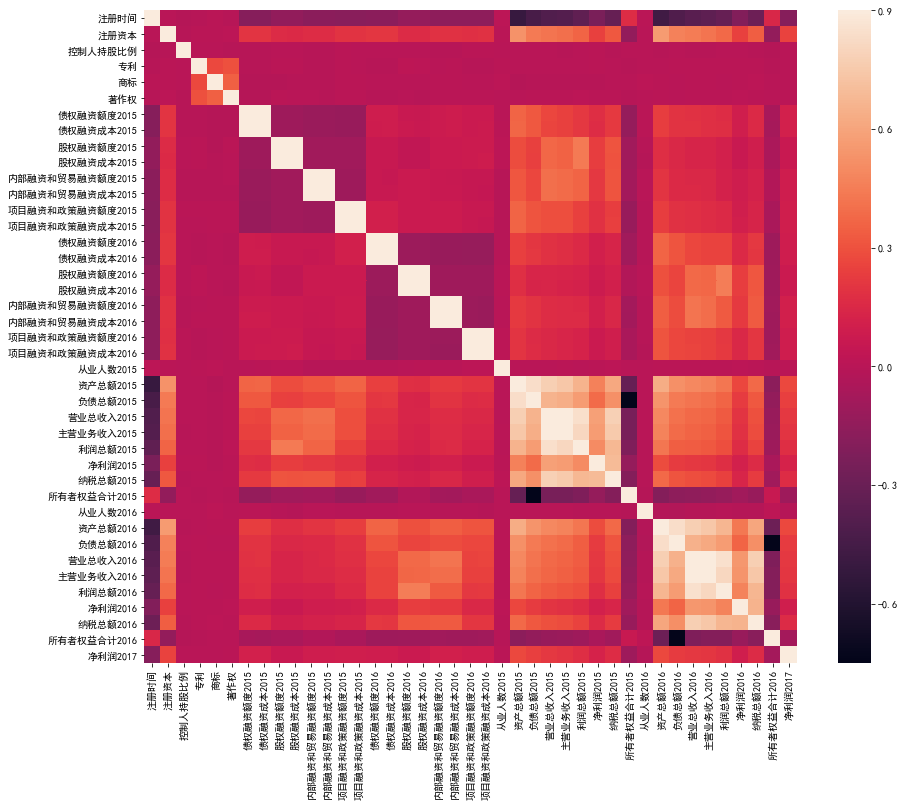

In [74]:
# 全部数值特征
corrmat = train322.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0d145f448>)

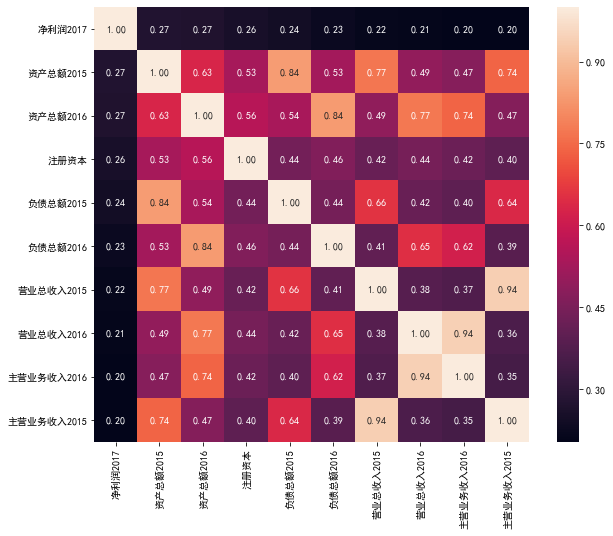

In [78]:
# 相关性最大的10个特征
corrmat = train322.corr()
plt.subplots(figsize=(10,8))
k = 10
cols = corrmat.nlargest(k, '净利润2017')['净利润2017'].index
cm = np.corrcoef(train322[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

###### 3.2.4 标签编码

In [142]:
#待编码的特征
cols_encode=['注册时间']

In [143]:
#将数值类型（数值作为类型的列）转化为字符串类型
feature=['注册时间']
for i in feature:
    train[i]=train[i].astype(str)

In [144]:
#对不连续的数字或文本进行编号，转换成连续的数值型变量
for c in cols_encode:
    le=LabelEncoder()
    all_data322[c]=le.fit_transform(list(all_data322[c].values))

In [145]:
#查看编码后的情况
all_data322[cols_encode].head()

,注册时间
0,8
1,8
2,8
3,2
4,5


###### 3.2.5 独热编码

In [146]:
# 独热编码用来解决类别型数据的离散值问题
all_data325 = pd.get_dummies(all_data322)
all_data325.head()

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,著作权,...,所有者权益合计2015,从业人数2016,资产总额2016,负债总额2016,营业总收入2016,主营业务收入2016,利润总额2016,净利润2016,纳税总额2016,所有者权益合计2016
0,8,1190.0,3,5,0,1,0.91,1.0,0.0,0.0,...,-30940.0,631.0,47600.0,69615.0,52360.0,20944.0,15708.0,-5236.0,0.0,-22015.0
1,8,6670.0,5,5,4,0,0.91,0.0,0.0,0.0,...,96715.0,353.0,106720.0,150075.0,74704.0,37352.0,29881.6,-7470.4,0.0,-43355.0
2,8,9100.0,4,4,0,0,0.51,1.0,0.0,1.0,...,-109200.0,84.0,291200.0,282100.0,145600.0,87360.0,29120.0,43680.0,87360.0,9100.0
3,2,5870.0,1,1,3,0,0.63,1.0,0.0,1.0,...,-29350.0,965.0,410900.0,607545.0,1150520.0,920416.0,115052.0,230104.0,230104.0,-196645.0
4,5,9850.0,2,3,4,0,0.58,0.0,0.0,0.0,...,-78800.0,213.0,325050.0,472800.0,1137675.0,682605.0,341302.5,341302.5,455070.0,-147750.0


###### 3.2.6 重新划分数据集

In [88]:
# 将处理好的数据重新划分成训练集和测试集，为模型训练与测试做准备
train326 = all_data325[:ntrain]
test326 = all_data325[ntrain:]

###### 3.2.7 特征重要性检测

In [89]:
lasso=Lasso(alpha=0.001)
lasso.fit(train326,y_train)

C:\Users\LERRY\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126347730693849.92, tolerance: 28415992188.507782
  positive)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [90]:
FI_lasso = pd.DataFrame({"特征重要性":lasso.coef_}, index=train326.columns)
FI_lasso.sort_values("特征重要性",ascending=False)

,特征重要性
著作权,1668.159810
企业类型,143.605531
注册资本,7.996649
股权融资成本2015,6.415303
债权融资成本2016,3.943163
内部融资和贸易融资成本2015,2.838004
从业人数2015,2.762574
债权融资额度2015,1.258808
项目融资和政策融资额度2016,1.013722
股权融资成本2016,0.578048


In [98]:
#只保存较重要的特征
cols327_1=year_train_res.columns.drop(['ID','净利润2017', '从业人数2017','资产总额2017','负债总额2017','营业总收入2017','主营业务收入2017','利润总额2017','纳税总额2017','所有者权益合计2017']).values.tolist()
cols327_2=money_train_res.columns.drop(['ID','债权融资额度2017','债权融资成本2017','股权融资额度2017','股权融资成本2017', '内部融资和贸易融资额度2017','内部融资和贸易融资成本2017','项目融资和政策融资额度2017','项目融资和政策融资成本2017']).values.tolist()
cols327_1.extend(cols327_2)
cols327=['著作权','企业类型','注册资本']
cols327.extend(cols327_1)
cols327

['著作权',
 '企业类型',
 '注册资本',
 '从业人数2015',
 '资产总额2015',
 '负债总额2015',
 '营业总收入2015',
 '主营业务收入2015',
 '利润总额2015',
 '净利润2015',
 '纳税总额2015',
 '所有者权益合计2015',
 '从业人数2016',
 '资产总额2016',
 '负债总额2016',
 '营业总收入2016',
 '主营业务收入2016',
 '利润总额2016',
 '净利润2016',
 '纳税总额2016',
 '所有者权益合计2016',
 '债权融资额度2015',
 '债权融资成本2015',
 '股权融资额度2015',
 '股权融资成本2015',
 '内部融资和贸易融资额度2015',
 '内部融资和贸易融资成本2015',
 '项目融资和政策融资额度2015',
 '项目融资和政策融资成本2015',
 '债权融资额度2016',
 '债权融资成本2016',
 '股权融资额度2016',
 '股权融资成本2016',
 '内部融资和贸易融资额度2016',
 '内部融资和贸易融资成本2016',
 '项目融资和政策融资额度2016',
 '项目融资和政策融资成本2016']

In [99]:
all_data327=all_data325.loc[:,cols327].copy()

In [100]:
# 将处理好的数据重新划分成训练集和测试集，为模型训练与测试做准备
train327 = all_data327[:ntrain]
test327 = all_data327[ntrain:]

In [103]:
train327.shape
test327.shape

(17319, 37)

(4068, 37)

# 4 基础模型

### 4.1 定义交叉验证策略

In [123]:
# cross_val_score默认使用K折交叉验证策略。此处先使用KFold的shuffle参数混洗数据
# neg_mean_squared_error：负均方误差，是损失函数，优化目标是使其最小化
n_splits = 5
def nmse_cv(model,train,y_train):
    kf = KFold(n_splits, shuffle=True, random_state=42).get_n_splits(train)
    nmse = np.sqrt(-cross_val_score(model, train, y_train, scoring='neg_mean_squared_error', cv=kf))
    return(nmse)

### 4.2 建立基础模型

In [102]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### 4.3 基础模型分数

In [111]:
#y_train归一化
mm=MinMaxScaler()
y_train43=mm.fit_transform(y_train.reshape(-1,1))

In [124]:
x_train43=train327.values

In [125]:
score = nmse_cv(model_xgb,x_train43,y_train43)
# 验证结果返回1个分数，求均值和标准差
print('model_xgb score:{:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))

model_xgb score:0.0674 (0.0004) 



# 5 模型训练与预测

### 5.1 定义评估函数

In [106]:
# 均方差：MSE的值越小，预测模型具有更好的精确度
def mse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### 5.2 模型训练、评估、预测

In [126]:
#训练集测试集8:2划分
X_train,X_test,y_train,y_test=train_test_split(x_train43, y_train43, test_size=0.2, random_state=2020)

In [128]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)
X_train

X_train (13855, 37)
y_train (13855, 1)
X_test (3464, 37)
y_test (3464, 1)


array([[0.0000e+00, 2.0000e+00, 2.2000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.0000e+00, 8.3000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.0000e+00, 2.1800e+03, ..., 7.8480e+02, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 3.0000e+00, 8.9700e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.0000e+00, 9.0800e+03, ..., 0.0000e+00, 3.6320e+02,
        2.1792e+01],
       [0.0000e+00, 3.0000e+00, 5.1300e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [129]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_test)
print(mse(y_test, xgb_train_pred))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method=None, validate_parameters=False, verbosity=None)

0.0710739186571407


In [139]:
#模型保存
import joblib

In [141]:
joblib.dump(model_xgb,'data//enterprise_profit_forecast/model/xgb.model')

['data//enterprise_profit_forecast/model/xgb.model']

In [ ]:
#加载模型
# model_xgb=joblib.load('data//enterprise_profit_forecast/model/xgb.model')

### 5.3 生成结果文件

In [131]:
pre52=test327.values

In [134]:
xgb_pred = np.expm1(model_xgb.predict(pre52))

In [135]:
xgb_pred

array([0.2827106 , 0.26691648, 0.2659227 , ..., 0.2593621 , 0.31098577,
       0.2810961 ], dtype=float32)

In [137]:
res = pd.DataFrame()
res['Id'] = test_Id
res['净利润'] = xgb_pred
res.to_csv('data/enterprise_profit_forecast/output/res.txt', index=False)